# Mapping Camera Coordinates to a 2D Floor Plan

This project demonstrates how to map 2D coordinates from a camera image onto a flat 2D floor plan (e.g., top-down map or schematic) using a **homography matrix**.

---

## Goal

Transform pixel coordinates of detected objects (e.g., people, robots, or balls) in a camera view to positions on a flat, scaled 2D map — without needing any physical camera calibration.

---

## How It Works

1. **Load an image** captured from a camera.
2. **Manually select 4 corner points** in the image corresponding to known corners on the map.
3. Define the corresponding corners on your **target 2D map (e.g., 1000×1000 pixels)**.
4. Compute the **homography matrix** using these point pairs.
5. Use the matrix to transform new image points to coordinates on the map.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(image_path):
    """
    Display an image using matplotlib.

    :param image_path: Path to the image file.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read the image at {image_path}")
    
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

    return image




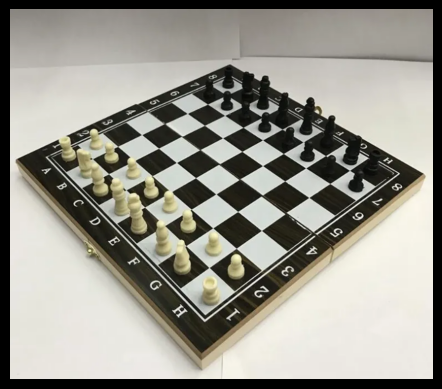

In [83]:
IMG = "../dataset/valid/images/IMG_1254_JPG.rf.3e5d069b50a45684bfe88db34b2c5173.jpg"
IMG = "chess.png"
MAP_WIDTH = 1000
MAP_HEIGHT = 1000
labels = ["top-left", "top-right", "bottom-right", "bottom-left"]

# Show example image and get its size
image_rgb = show_image(IMG)

In [123]:
import cv2
import numpy as np

def safe_text_position(x, y, label, img_shape):
    """Ensure text stays within image bounds."""
    text_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
    text_width, text_height = text_size
    offset_x, offset_y = 10, -10

    x_new = x + offset_x
    y_new = y + offset_y

    # Correct x if text goes beyond right edge
    if x_new + text_width > img_shape[1]:
        x_new = x - text_width - offset_x
    # Correct x if text goes beyond left edge
    if x_new < 0:
        x_new = 0
    # Correct y if text goes above top
    if y_new - text_height < 0:
        y_new = y + text_height + offset_y

    return (x_new, y_new)


def select_points(image):
    """
    Allow the user to select 4 points on the image.
    The points will be used to define a region of interest.
    :param image: The image on which to select points.
    :return: A tuple (points, annotated_image) where:
             - points is a list of tuples containing the selected points (x, y)
             - annotated_image is a copy of the image with the points and lines drawn on it
    """
    if image is None:
        raise ValueError("Image is None. Please provide a valid image.")
    if not isinstance(image, np.ndarray):
        raise TypeError("Image must be a numpy array.")
    if image.shape[0] == 0 or image.shape[1] == 0:
        raise ValueError("Image is empty. Please provide a valid image.")
    if image.shape[2] != 3:
        raise ValueError("Image must be a 3-channel (RGB) image.")

    points = []
    instructions = [
        "Choose 1 point (top-left)",
        "Choose 2 point (top-right)",
        "Choose 3 point (bottom-right)",
        "Choose 4 point (bottom-left)"
    ]
    labels = ["top-left", "top-right", "bottom-right", "bottom-left"]

    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
            points.append((x, y))
            print(f"Chosen point {len(points)}: {x}, {y}")


    clone = image.copy()
    cv2.namedWindow("Click 4 points")
    cv2.setMouseCallback("Click 4 points", mouse_callback)

    while True:
        temp = clone.copy()
        if len(points) < 4:
            cv2.putText(temp, instructions[len(points)], (20, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2, cv2.LINE_AA)

        for idx, p in enumerate(points):
            label = f"{idx + 1} ({labels[idx]})"
            cv2.circle(temp, p, 5, (0, 0, 255), -1)
            pos = safe_text_position(p[0], p[1], label, temp.shape)
            cv2.putText(temp, label, pos, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        cv2.imshow("Click 4 points", temp)

        if len(points) == 4:
            annotated_image = temp.copy()
            for i in range(4):
                pt1 = points[i]
                pt2 = points[(i + 1) % 4]
                cv2.line(annotated_image, pt1, pt2, (0, 255, 255), 2)
            break

        if cv2.waitKey(1) & 0xFF == 27:
            print("Przerwano wybór punktów.")
            cv2.destroyAllWindows()
            return None, None

    cv2.destroyAllWindows()
    return points, annotated_image


def show_selected_points_with_coordinates(image, points, labels):
    """
    Display the selected points on the image with their coordinates.
    
    :param image: The image on which the points were selected.
    :param points: List of tuples containing the selected points (x, y).
    """
    if image is None or points is None:
        raise ValueError("Image or points are None. Please provide valid inputs.")
    
    temp = image.copy()
    for idx, (x, y) in enumerate(points):
        label = f"{idx + 1} ({labels[idx]})"
        cv2.circle(temp, (x, y), 5, (0, 0, 255), -1)
        pos = safe_text_position(x, y, label, temp.shape)
        cv2.putText(temp, label, pos, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        

    return temp



def calculate_H(points, map_width, map_height):
    """
    Calculate the homography matrix from the selected points to the desired map size.
    
    :param points: List of tuples containing the selected points (x, y).
    :param map_width: Desired width of the output map.
    :param map_height: Desired height of the output map.
    :return: The homography matrix.
    """

    
    if len(points) != 4:
        raise ValueError("Exactly 4 points are required to calculate homography.")

    src_points = np.array(points, dtype='float32')
    dst_points = np.array([[0, 0], [map_width-1, 0], [map_width-1, map_height-1], [0, map_height-1]], dtype='float32')

    H = cv2.getPerspectiveTransform(src_points, dst_points)
    return H


def apply_homography(image, H, map_width, map_height):
    """
    Apply the homography transformation to the image.
    
    :param image: The input image.
    :param H: The homography matrix.
    :param map_width: Desired width of the output map.
    :param map_height: Desired height of the output map.
    :return: The transformed image.
    """
    if image is None:
        raise ValueError("Image is None. Please provide a valid image.")
    
    transformed_image = cv2.warpPerspective(image, H, (map_width, map_height))
    return transformed_image

def calculate_new_coordinate(x, y, H):
    """
    Calculate new coordinates using homography matrix H.
    
    :param x: x coordinate on the original image
    :param y: y coordinate on the original image
    :param H: 3x3 homography matrix
    :return: (new_x, new_y) transformed coordinates as integers
    """
    point = np.array([[[x, y]]], dtype=np.float32)  # shape (1, 1, 2)
    transformed = cv2.perspectiveTransform(point, H)
    new_x, new_y = transformed[0][0]
    return int(round(new_x)), int(round(new_y))




Chosen point 1: 396, 99
Chosen point 2: 18, 274
Chosen point 3: 346, 622
Chosen point 4: 747, 300
[(396, 99), (18, 274), (346, 622), (747, 300)]
Homography matrix:
[[-2.16224947e+00  3.77586848e+00  4.82439811e+02]
 [ 1.92917502e+00  4.16701805e+00 -1.17648809e+03]
 [-1.21929382e-05  1.75111804e-03  1.00000000e+00]]


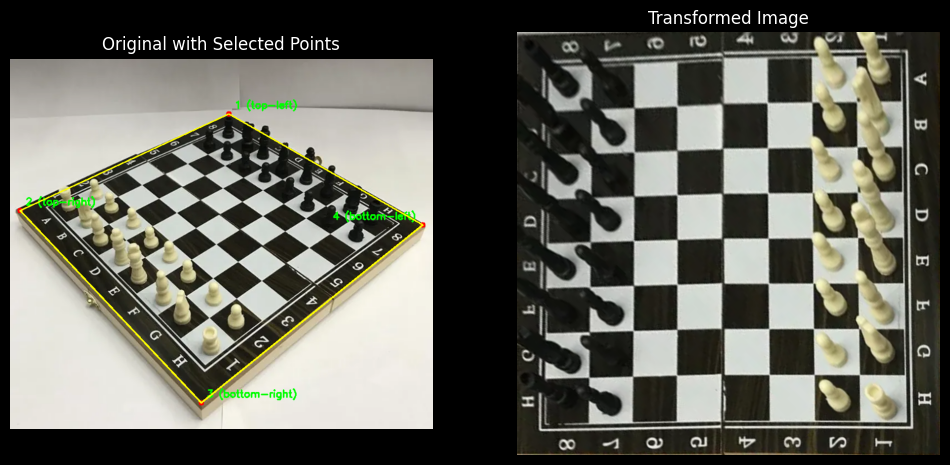

In [132]:
points, img_with_selected_points  = select_points(image_rgb)

print(points)
H = calculate_H(points, MAP_WIDTH, MAP_HEIGHT)
print("Homography matrix:")
print(H)

transformed_image = apply_homography(image_rgb, H, MAP_WIDTH, MAP_HEIGHT)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Lewy obraz: img_with_selected_points
axes[0].imshow(cv2.cvtColor(img_with_selected_points, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original with Selected Points")
axes[0].axis('off')

# Prawy obraz: transformed_image
axes[1].imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
axes[1].set_title("Transformed Image")
axes[1].axis('off')

#plt.tight_layout()
plt.show()
